In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
#from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing
#import cv2
import PIL

# Q1

In [2]:
X_df = pd.read_csv("x_train.csv", header = None)
Y_df = pd.read_csv("t_train.csv", header = None)
X = X_df.to_numpy()
Y = Y_df.to_numpy().flatten()

In [3]:
class PCA_hw:
    def __init__(self, n_pc = None):
        self.n_pc = n_pc
    
    def fit(self, X):
        X = X - np.mean(X, axis = 0)
        C = np.dot(X.T, X) / (X.shape[0] - 1)
        self.eig_vals, self.eig_vecs = np.linalg.eig(C)

    def transform(self, X_new):
        if self.n_pc == None:
            self.n_pc = (np.min([X_new.shape[0], X_new.shape[1]]))
        X_new = X_new - np.mean(X_new, axis = 0)
        X_pca = np.dot(X_new, self.eig_vecs)
        X_pca = X_pca * np.array([1 if (i%2 == 0) else -1 for i in range(X_new.shape[1])])
        X_pca = X_pca[:,:(np.min([X_new.shape[0], X_new.shape[1]]))]
        X_pca = X_pca.real[:,[i for i in range(self.n_pc)]]
        return X_pca
    
def poly(X):
        X_new = (X[:,0]**2).reshape(-1,1)
        X_new = np.append(X_new, (np.sqrt(2)*X[:,0]*X[:,1]).reshape(-1,1),axis = 1)
        X_new = np.append(X_new, (X[:,1]**2).reshape(-1,1),axis = 1)
        return X_new
    
class SVM:
    def __init__(self, X, Y, Poly = False):
        #self.pca = PCA_hw()
        #self.pca.fit(X)
        self.X = X #self.pca.transform(X)[:,[0,1]]
        self.Poly = Poly
        #if self.Poly:
        #    self.X = poly(self.X)
        self.Y = Y
    
    def one_versus_the_rest(self, X_test):
        #X_test = self.pca.transform(X_test)[:,[0,1]]
        #if self.Poly:
        #    X_test = poly(X_test)
        result = np.zeros((len(X_test), len(np.unique(self.Y))))
        self.SV_rest = np.array([])
        for i in np.unique(self.Y):
            Y = np.where(self.Y == i, 1, 0)
            model = svm.SVC(kernel = "linear")
            model.fit(self.X, Y)
            self.SV_rest = np.append(self.SV_rest, model.support_)
            w = (model.dual_coef_ @ model.support_vectors_)[0]
            Y_pred = np.where((X_test @ w.T + model.intercept_) > 0, 1, 0).flatten()
            result[:,i] += Y_pred
        self.SV_rest = np.unique(self.SV_rest).astype(int)
        return np.argmax(result, axis=1)
    
    def one_versus_one(self, X_test):
        #X_test = self.pca.transform(X_test)[:,[0,1]]
        #if self.Poly:
        #    X_test = poly(X_test)
        result = np.zeros((len(X_test), len(np.unique(self.Y))))
        comb = [[0,1],[1,2],[0,2]]
        self.SV_one = np.array([])
        for i in comb:
            ind = np.where((self.Y == i[0]) | (self.Y == i[1]))[0]
            Y = self.Y[ind]
            X = self.X[ind]
            Y = np.where(Y == i[0], 1, 0)
                      
            model = svm.SVC(kernel = "linear")
            model.fit(X, Y)
            self.SV_one = np.append(self.SV_one, model.support_)
            w = (model.dual_coef_ @ model.support_vectors_)[0]
            Y_pred_i0 = np.where((X_test @ w.T + model.intercept_) > 0, 1,0).flatten()
            Y_pred_i1 = np.where((X_test @ w.T + model.intercept_) > 0, 0,1).flatten()
            result[:,i[0]] += Y_pred_i0
            result[:,i[1]] += Y_pred_i1
        self.SV_one = np.unique(self.SV_one).astype(int)
        return np.argmax(result, axis=1)

## Q1.1

In [4]:
pca = PCA_hw(n_pc = 2)
pca.fit(X)

In [5]:
pca.transform(X)[:5]

array([[ 262.8708395 ,  -67.34140921],
       [-117.7650028 ,   -1.56445322],
       [  42.59562812, -188.39139909],
       [ 333.86765942,  -70.59525325],
       [-131.82140584,    9.18481242]])

## Q1.3

In [6]:
X_pca = pca.transform(X)
X_poly = poly(X_pca)

In [7]:
dx = np.linspace(np.min(X_pca[:, 0]-10), np.max(X_pca[:, 0]+10), 2000)
dy = np.linspace(np.min(X_pca[:, 1]-10), np.max(X_pca[:, 1]+10), 2000)
dx, dy = np.meshgrid(dx, dy)

In [8]:
model1 = SVM(X_pca,Y)
linear_one_rest = model1.one_versus_the_rest(X_pca)
linear_one_one = model1.one_versus_one(X_pca)

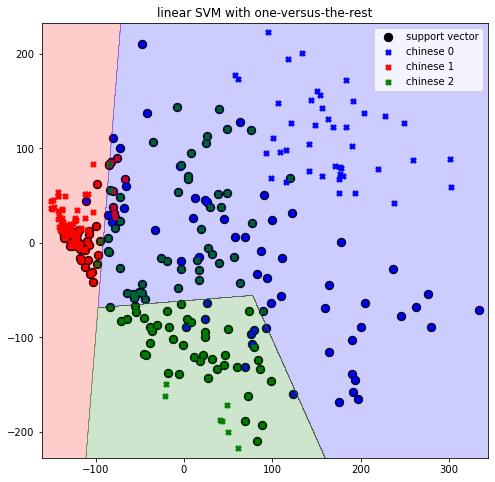

In [9]:
plt.figure(figsize = (8,8))
plt.scatter(X_pca[model1.SV_rest,0], X_pca[model1.SV_rest,1],c = "black", s =70,label = "support vector", marker = "o")
plt.scatter(X_pca[np.where(Y==0)[0],0],X_pca[np.where(Y==0)[0],1], c = "b", s =30, marker = "X", label = "chinese 0")
plt.scatter(X_pca[np.where(Y==1)[0],0],X_pca[np.where(Y==1)[0],1], c = "r",s =30, marker = "X", label = "chinese 1")
plt.scatter(X_pca[np.where(Y==2)[0],0],X_pca[np.where(Y==2)[0],1], c = "g",s =30, marker = "X", label = "chinese 2")
plt.contourf(dx, dy, model1.one_versus_the_rest(np.c_[dx.ravel(), dy.ravel()]).reshape(dx.shape),
             alpha=0.2, cmap = ListedColormap(["b", "r", "g"]))
plt.xlim(np.min(X_pca[:,0])-10, np.max(X_pca[:,0])+10)
plt.ylim(np.min(X_pca[:,1])-10, np.max(X_pca[:,1])+10)
plt.title("linear SVM with one-versus-the-rest")
plt.legend()
plt.show()

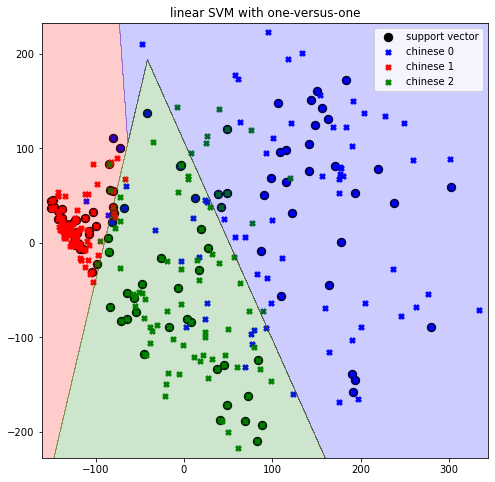

In [10]:
plt.figure(figsize = (8,8))
plt.scatter(X_pca[model1.SV_one,0],X_pca[model1.SV_one,1],c = "black", s =70,label = "support vector", marker = "o")
plt.scatter(X_pca[np.where(Y==0)[0],0],X_pca[np.where(Y==0)[0],1], c = "b", s =30, marker = "X", label = "chinese 0")
plt.scatter(X_pca[np.where(Y==1)[0],0],X_pca[np.where(Y==1)[0],1], c = "r", s =30, marker = "X", label = "chinese 1")
plt.scatter(X_pca[np.where(Y==2)[0],0],X_pca[np.where(Y==2)[0],1], c = "g", s =30, marker = "X", label = "chinese 2")
plt.contourf(dx, dy, model1.one_versus_one(np.c_[dx.ravel(), dy.ravel()]).reshape(dx.shape),
             alpha=0.2, cmap = ListedColormap(["b", "r", "g"]))
plt.xlim(np.min(X_pca[:,0])-10, np.max(X_pca[:,0])+10)
plt.ylim(np.min(X_pca[:,1])-10, np.max(X_pca[:,1])+10)
plt.title("linear SVM with one-versus-one")
plt.legend()
plt.show()

## Q1.4

In [11]:
model2 = SVM(X_poly,Y)#,Poly = True)
poly_one_rest = model2.one_versus_the_rest(X_poly)
poly_one_one = model2.one_versus_one(X_poly)

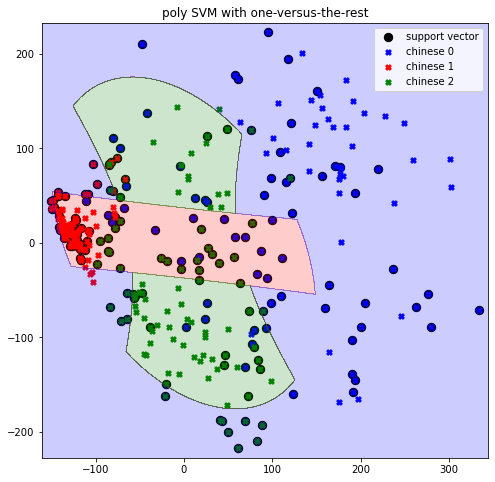

In [12]:
plt.figure(figsize = (8,8))
plt.scatter(X_pca[model2.SV_rest,0], X_pca[model2.SV_rest,1],c = "black", s =70,label = "support vector", marker = "o")
plt.scatter(X_pca[np.where(Y==0)[0],0],X_pca[np.where(Y==0)[0],1], c = "b", s =30, marker = "X", label = "chinese 0")
plt.scatter(X_pca[np.where(Y==1)[0],0],X_pca[np.where(Y==1)[0],1], c = "r", s =30, marker = "X", label = "chinese 1")
plt.scatter(X_pca[np.where(Y==2)[0],0],X_pca[np.where(Y==2)[0],1], c = "g",s =30, marker = "X", label = "chinese 2")
plt.contourf(dx, dy, model2.one_versus_the_rest(poly(np.c_[dx.ravel(), dy.ravel()])).reshape(dx.shape),
             alpha=0.2, cmap = ListedColormap(["b", "r", "g"]))
plt.xlim(np.min(X_pca[:,0])-10, np.max(X_pca[:,0])+10)
plt.ylim(np.min(X_pca[:,1])-10, np.max(X_pca[:,1])+10)
plt.title("poly SVM with one-versus-the-rest")
plt.legend()
plt.show()

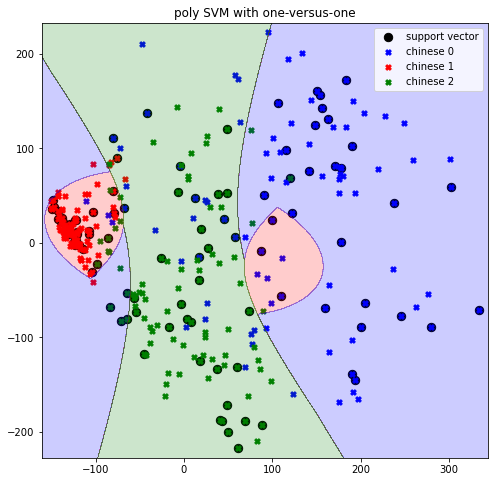

In [13]:
plt.figure(figsize = (8,8))
plt.scatter(X_pca[model2.SV_one,0], X_pca[model2.SV_one,1],c = "black", s =70,label = "support vector", marker = "o")
plt.scatter(X_pca[np.where(Y==0)[0],0],X_pca[np.where(Y==0)[0],1], c = "b", s =30, marker = "X", label = "chinese 0")
plt.scatter(X_pca[np.where(Y==1)[0],0],X_pca[np.where(Y==1)[0],1], c = "r", s =30, marker = "X", label = "chinese 1")
plt.scatter(X_pca[np.where(Y==2)[0],0],X_pca[np.where(Y==2)[0],1], c = "g",s =30, marker = "X", label = "chinese 2")
plt.contourf(dx, dy, model2.one_versus_one(poly(np.c_[dx.ravel(), dy.ravel()])).reshape(dx.shape),
             alpha=0.2, cmap = ListedColormap(["b", "r", "g"]))
plt.xlim(np.min(X_pca[:,0])-10, np.max(X_pca[:,0])+10)
plt.ylim(np.min(X_pca[:,1])-10, np.max(X_pca[:,1])+10)
plt.title("poly SVM with one-versus-one")
plt.legend()
plt.show()

## Q1.5

one PDF

# Q2

In [14]:
img = PIL.Image.open("hw3.jpg")
np_img = np.array(img)

In [15]:
X = np_img.copy()
X = X.reshape(-1,3)
#X = X.astype(float)

In [16]:
class KMEANS:
    def __init__(self, n_clusters, max_iter = 100, init = None):
        self.k = n_clusters
        self.max = max_iter
        if init != None:
            np.random.seed(init)
    def fit(self, X):
        X = X.astype(float)
        self.c = X[np.random.choice(len(X), self.k, replace=False)]
        c_last = np.zeros((self.k, X.shape[1]))
        
        self.label = np.array([-1 for i in range(X.shape[0])])
        self.n = 0
        while ((c_last != self.c).any() and self.n < self.max):
            c_last = self.c.copy()
            for i in range(len(X)):
                self.label[i] = np.argmin(np.sqrt(np.sum((X[i] - c_last)**2, axis=1)))
            for i in range(self.k):
                self.c[i,:] = np.mean(X[np.where(self.label == i)[0]], axis=0)
            self.n += 1
class EM:
    def __init__(self, X, init_mu, max_iter = 100):
        self.k = init_mu.shape[0]
        self.max = max_iter
        self.mu = init_mu
        
        init_sigma = np.zeros((self.k, init_mu.shape[1], init_mu.shape[1]))
        for i in range(self.k):
            init_sigma[i] = np.eye(init_mu.shape[1])
        self.sigma = init_sigma
        
        self.pi = np.ones(self.k)/self.k
        self.z = np.full((X.shape[0], self.k), 1/self.k)
        self.X = X.astype(float)
    def fit(self):
        
        n = 0
        self.ll_lst = []
        while n < self.max:
            self.e_step()
            self.m_step()
            self.ll_lst.append(self.log_likelihood())
            #print(n)
            n += 1
        self.label = np.argmax(self.z, axis = 1)
        
    def e_step(self):
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.X, mean=self.mu[i], cov=self.sigma[i])
        self.z /= np.where(np.sum(self.z, axis=1, keepdims=True)==0, 1, np.sum(self.z, axis=1, keepdims=True))

    def m_step(self):
        sum_z = np.sum(self.z, axis=0)
        self.pi = sum_z / self.X.shape[0]
        self.mu = (self.z.T @ self.X)
        self.mu /= sum_z.reshape(-1, 1)
        for i in range(self.k):
            j = np.expand_dims(self.X, axis=1) - self.mu[i]
            s = j.transpose([0, 2, 1]) @ j
            self.sigma[i] = s.transpose(1, 2, 0) @ self.z[:, i]
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self):
        ll = np.zeros(len(self.X))
        for i in range(self.k):
            ll += self.pi[i] * multivariate_normal.pdf(self.X, mean=self.mu[i], cov=self.sigma[i])
        return np.sum(np.log(ll))

## Q2.1/2/3

### k = 3

In [17]:
clt3 = KMEANS(n_clusters = 3, init = 0)
clt3.fit(X)

em3 = EM(X, clt3.c)
em3.fit()

In [18]:
pd.DataFrame(clt3.c, columns = ["layer1","layer2","layer3"],
             index = ["$"+"\mu_"+ str(i) +"$" for i in range(1,len(clt3.c)+1)])

,layer1,layer2,layer3
$\mu_1$,35.972376,31.837745,18.696179
$\mu_2$,106.092063,118.348664,77.754595
$\mu_3$,177.561464,186.947234,189.730905


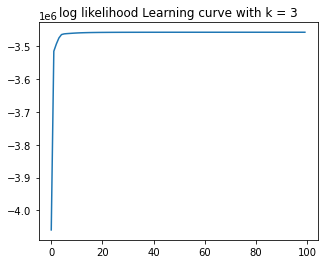

In [19]:
plt.figure(figsize = (5, 4))
plt.plot(em3.ll_lst)
plt.title("log likelihood Learning curve with k = 3")
plt.show()

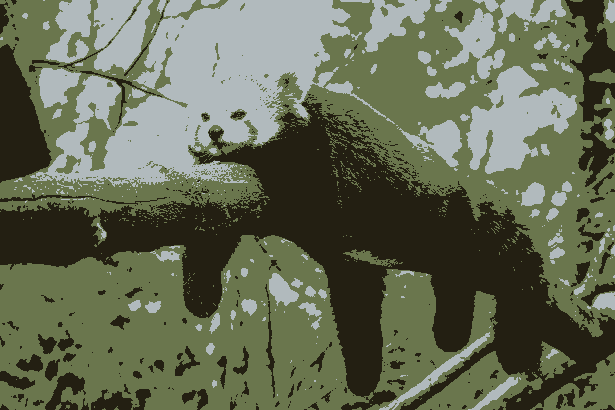

In [20]:
PIL.Image.fromarray(np.uint8(clt3.c)[clt3.label].reshape(np_img.shape))

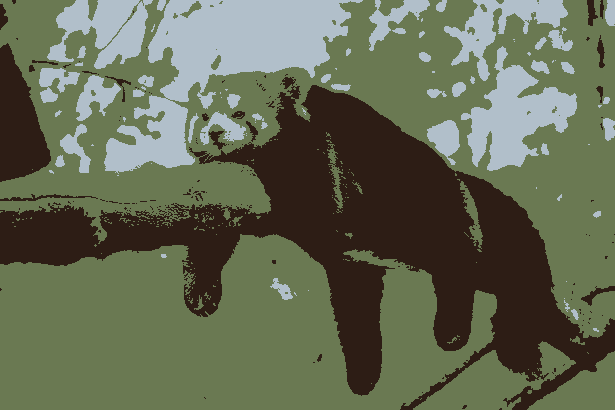

In [21]:
PIL.Image.fromarray(np.uint8(em3.mu)[em3.label].reshape(np_img.shape))

### k = 7

In [22]:
clt7 = KMEANS(n_clusters = 7, init = 0)
clt7.fit(X)

em7 = EM(X, clt7.c)
em7.fit()

In [23]:
pd.DataFrame(clt7.c, columns = ["layer1","layer2","layer3"],
             index = ["$"+"\mu_"+ str(i) +"$" for i in range(1,len(clt7.c)+1)])

,layer1,layer2,layer3
$\mu_1$,18.993761,14.308196,9.609758
$\mu_2$,60.058279,52.805790,31.909421
$\mu_3$,82.563968,99.365956,51.482241
$\mu_4$,208.874969,217.456553,227.112743
$\mu_5$,138.541667,145.793515,123.318427
$\mu_6$,163.458079,174.572107,177.424651
$\mu_7$,112.567392,124.682212,81.976501


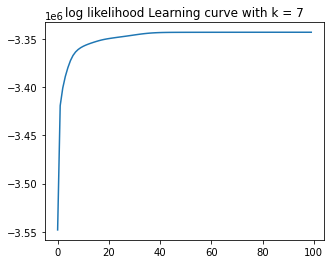

In [24]:
plt.figure(figsize = (5, 4))
plt.plot(em7.ll_lst)
plt.title("log likelihood Learning curve with k = 7")
plt.show()

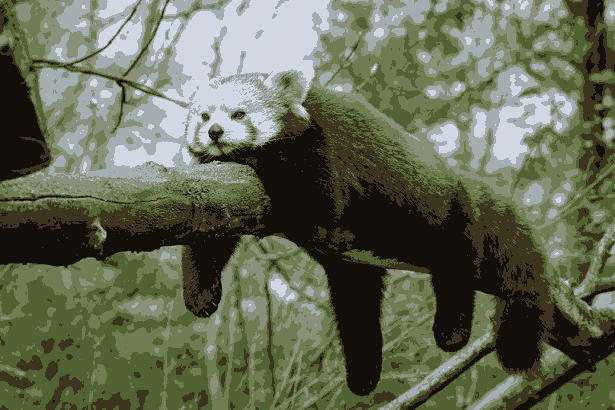

In [25]:
PIL.Image.fromarray(np.uint8(clt7.c)[clt7.label].reshape(np_img.shape))

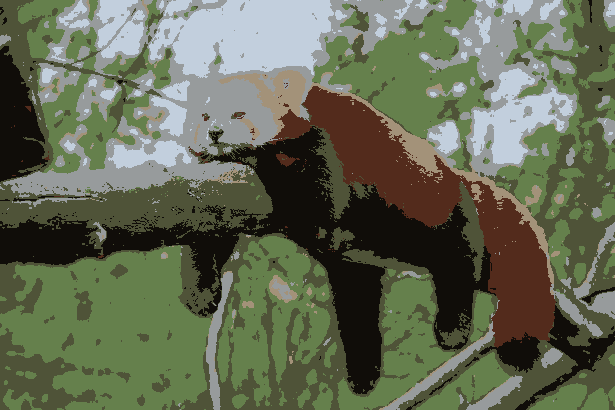

In [26]:
PIL.Image.fromarray(np.uint8(em7.mu)[em7.label].reshape(np_img.shape))

### k = 10

In [27]:
clt10 = KMEANS(n_clusters = 10, init = 0)
clt10.fit(X)

em10 = EM(X, clt10.c)
em10.fit()

In [28]:
pd.DataFrame(clt10.c, columns = ["layer1","layer2","layer3"],
             index = ["$"+"\mu_{"+ str(i) +"}" +"$" for i in range(1,len(clt10.c)+1)])

,layer1,layer2,layer3
$\mu_{1}$,17.907305,13.421935,8.989922
$\mu_{2}$,72.194497,94.876363,42.826658
$\mu_{3}$,129.703188,74.294467,49.833448
$\mu_{4}$,213.471838,221.729611,231.445759
$\mu_{5}$,95.620903,103.319506,82.072563
$\mu_{6}$,148.008966,157.368665,150.415909
$\mu_{7}$,130.114233,138.265840,105.014106
$\mu_{8}$,101.299616,130.783148,63.688988
$\mu_{9}$,55.651178,46.457484,30.410801
$\mu_{10}$,174.465440,185.641163,192.293333


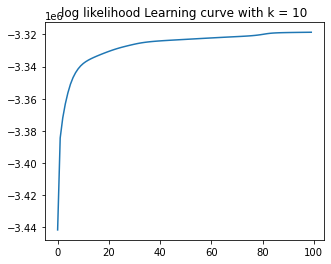

In [29]:
plt.figure(figsize = (5, 4))
plt.plot(em10.ll_lst)
plt.title("log likelihood Learning curve with k = 10")
plt.show()

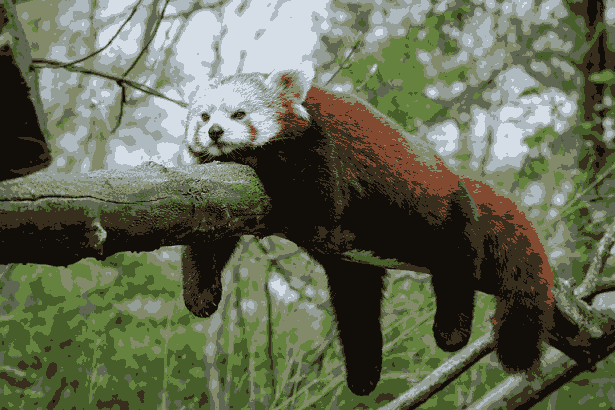

In [30]:
PIL.Image.fromarray(np.uint8(clt10.c)[clt10.label].reshape(np_img.shape))

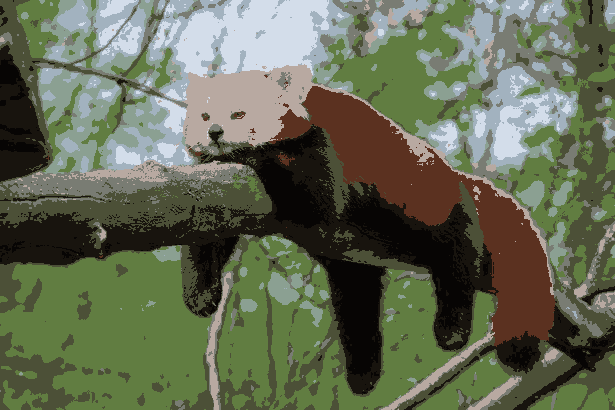

In [31]:
PIL.Image.fromarray(np.uint8(em10.mu)[em10.label].reshape(np_img.shape))

### k = 30

In [32]:
clt30 = KMEANS(n_clusters = 30, init = 0)
clt30.fit(X)

em30 = EM(X, clt30.c)
em30.fit()

In [33]:
pd.DataFrame(clt30.c, columns = ["layer1","layer2","layer3"],
             index = ["$"+"\mu_{"+ str(i)+"}" +"$" for i in range(1,len(clt30.c)+1)])

,layer1,layer2,layer3
$\mu_{1}$,63.334859,29.428571,13.825905
$\mu_{2}$,94.624406,101.146996,80.347368
$\mu_{3}$,162.262634,101.860568,70.544817
$\mu_{4}$,182.444474,197.648580,210.773230
$\mu_{5}$,128.239872,134.829160,113.089239
$\mu_{6}$,123.950146,140.310630,142.181930
$\mu_{7}$,139.072660,157.874088,102.074833
$\mu_{8}$,103.627323,127.182990,71.704838
$\mu_{9}$,94.200472,49.168276,31.411032
$\mu_{10}$,206.666302,216.384063,227.552920


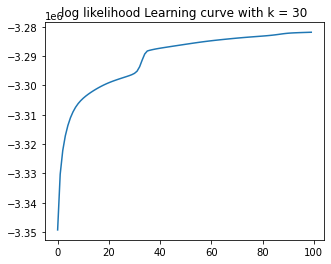

In [34]:
plt.figure(figsize = (5, 4))
plt.plot(em30.ll_lst)
plt.title("log likelihood Learning curve with k = 30")
plt.show()

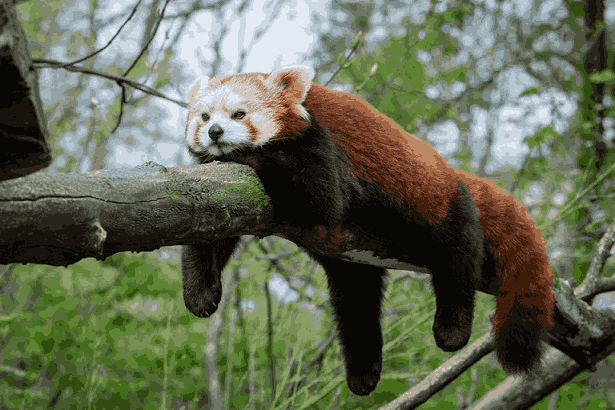

In [35]:
PIL.Image.fromarray(np.uint8(clt30.c)[clt30.label].reshape(np_img.shape))

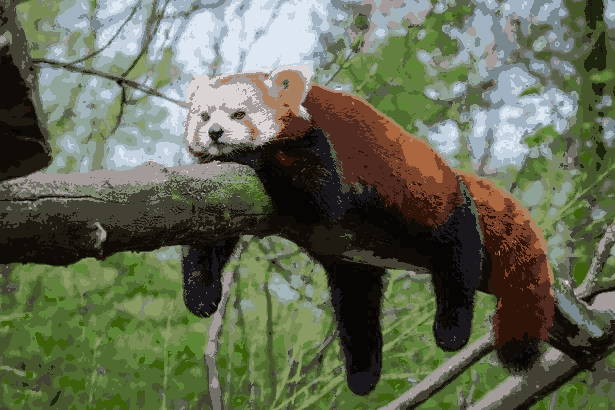

In [36]:
PIL.Image.fromarray(np.uint8(em30.mu)[em30.label].reshape(np_img.shape))

### Original

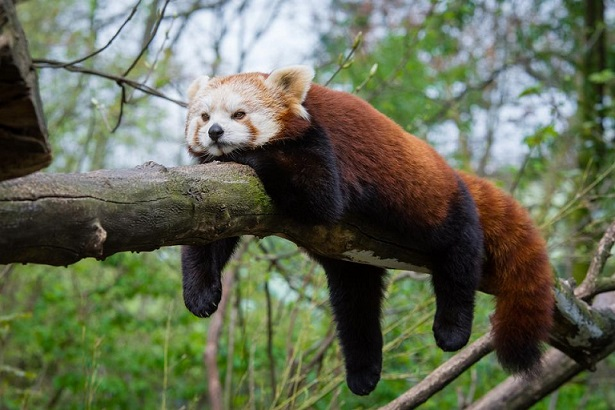

In [37]:
img

## Q2.4

on PDF